## Regularisation for Logistic Regression

We will demonstrate how **regularisation** can help address overfitting in binary logistic regression using a dataset of network information, where the goal is to predict whether a network attack is detected

In addition, we will carry out **hyperparameter tuning** to identify the optimal regularisation strength

Let's start by importing the necessary libraries

**Logistic Regression and Regularization**

- Logistic regression in scikit-learn supports L1 (Lasso-like) and L2 (Ridge-like) regularization through the penalty parameter.

- Instead of alpha like in Ridge/Lasso, logistic regression uses C (inverse of regularization strength):

𝐶 = 1 / 𝜆

- Small C → stronger regularization.
- Large C → weaker regularization.

**LogisticRegressionCV**

```python
from sklearn.linear_model import LogisticRegressionCV

log_reg_cv = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],   # list of C values to try
    cv=5,                    # 5-fold cross-validation
    penalty="l2",            # or "l1" (requires solver="liblinear" or "saga")
    solver="liblinear",
    max_iter=1000
)

log_reg_cv.fit(X, y)
print("Best C:", log_reg_cv.C_)
```

In [1]:
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.preprocessing import MinMaxScaler  # Scaling
from sklearn.model_selection import train_test_split, GridSearchCV  # Train-test split and grid search for hyperparameter tuning
from sklearn.metrics import accuracy_score  # Classification performance
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns  # Data processing and visualisation
import warnings; warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/network_data.csv', index_col = 'session_id').iloc[:99, :]; df.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
session_id,,,,,,,,,,
SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, SID_00001 to SID_00099
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  99 non-null     int64  
 1   protocol_type        99 non-null     object 
 2   login_attempts       99 non-null     int64  
 3   session_duration     99 non-null     float64
 4   encryption_used      77 non-null     object 
 5   ip_reputation_score  99 non-null     float64
 6   failed_logins        99 non-null     int64  
 7   browser_type         99 non-null     object 
 8   unusual_time_access  99 non-null     int64  
 9   attack_detected      99 non-null     int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 8.5+ KB


In [4]:
df['encryption_used'].unique()

array(['DES', 'AES', nan], dtype=object)

When there's no encryption used (i.e., `'encryption_used'` contains null values), we can consider it as a category of its own; so let's set this to the string `'None'`

In [5]:
df['encryption_used'] = df['encryption_used'].fillna('None')  # Assume null values mean there is no encryption

We can see that our data contains a mix of numerical and categorical predictors; let's perform one-hot encoding on the categorical predictors

In [6]:
df_with_dummies = pd.get_dummies(df, drop_first = True)  # One-hot encoding
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, SID_00001 to SID_00099
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   network_packet_size   99 non-null     int64  
 1   login_attempts        99 non-null     int64  
 2   session_duration      99 non-null     float64
 3   ip_reputation_score   99 non-null     float64
 4   failed_logins         99 non-null     int64  
 5   unusual_time_access   99 non-null     int64  
 6   attack_detected       99 non-null     int64  
 7   protocol_type_TCP     99 non-null     bool   
 8   protocol_type_UDP     99 non-null     bool   
 9   encryption_used_DES   99 non-null     bool   
 10  encryption_used_None  99 non-null     bool   
 11  browser_type_Edge     99 non-null     bool   
 12  browser_type_Firefox  99 non-null     bool   
 13  browser_type_Safari   99 non-null     bool   
 14  browser_type_Unknown  99 non-null     bool   
dtypes: bool(8), flo

Let's proceed by performing a train-test split on our data

In [7]:
X = df_with_dummies.drop('attack_detected', axis = 1); 
y = df_with_dummies['attack_detected']  # Predictors and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)  # Train-test split
print('Dimensions of X_train:', X_train.shape); print('Dimensions of y_train:', y_train.shape)
print('Dimensions of X_test:', X_test.shape); print('Dimensions of y_test:', y_test.shape)

Dimensions of X_train: (69, 14)
Dimensions of y_train: (69,)
Dimensions of X_test: (30, 14)
Dimensions of y_test: (30,)


Let's now check to see if our numerical predictors are on the same scale

In [8]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
network_packet_size,99.0,479.929293,180.229630,64.000000,379.000000,476.000000,587.000000,870.000000
login_attempts,99.0,4.393939,2.079139,1.000000,3.000000,4.000000,6.000000,10.000000
session_duration,99.0,798.338874,674.090239,12.599906,295.923872,568.528898,1241.901865,3325.308689
ip_reputation_score,99.0,0.353831,0.188479,0.035139,0.207762,0.339711,0.469808,0.870834
failed_logins,99.0,1.505051,0.993589,0.000000,1.000000,2.000000,2.000000,4.000000
unusual_time_access,99.0,0.161616,0.369972,0.000000,0.000000,0.000000,0.000000,1.000000


We can see here that our predictors are not on the same scale

In general, and **especially while regularising our data**, it is important that our predictors be on the same scale; we will use min-max scaling to achieve this

Remember, you should fit the scaler only on the training data and then apply that fitted transformation to the testing data. This ensures the testing set remains unseen and unbiased, while still being scaled consistently with the training data.

In [9]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's now fit our data to a logistic regression model and evaluate the accuracy of its predictions

In [10]:
logreg_model = LogisticRegression(); 
logreg_model.fit(X_train, y_train)  # Fitting logistic regression model on training data
y_pred_train = logreg_model.predict(X_train); 
y_pred_test = logreg_model.predict(X_test)  # Training and testing predictions
acc_train = accuracy_score(y_train, y_pred_train); 
acc_test = accuracy_score(y_test, y_pred_test)  # Training and testing accuracies
print('Training accuracy =', np.round(acc_train, 2)); print('Testing accuracy =', np.round(acc_test, 2))

Training accuracy = 0.78
Testing accuracy = 0.67


### Lasso (L1) Regularisation

Let's now apply lasso regularisation using the `'liblinear'` solver; this solver supports L1 regularisation. liblinear is typically used for small datasets.

The parameter `C` is the inverse of regularisation strength $\alpha$, i.e., a larger `C` means we are trusting our data more. We will start with a `C = 100`

In [13]:
logreg_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 100); 
logreg_model.fit(X_train, y_train)  # Model fit
y_pred_train = logreg_model.predict(X_train); 
y_pred_test = logreg_model.predict(X_test)  # Predictions
acc_train = accuracy_score(y_train, y_pred_train); 
acc_test = accuracy_score(y_test, y_pred_test)  # Accuracies
print('Training accuracy =', np.round(acc_train, 2)); 
print('Testing accuracy =', np.round(acc_test, 2))

Training accuracy = 0.78
Testing accuracy = 0.73


`C` is a **hyperparameter** as it is set before training begins. Let's try to find an ideal `C` value by performing hyperparameter tuning using `GridSearchCV()` from `sklearn.model_selection`. This function will search a 'grid' of parameters, which is essentially an array of different `C` values.

In [14]:
# Define parameter grid
param_grid = {'C': np.logspace(-3, 3, num = 7)}  # from 0.001 to 1000 (logarithmic)
param_grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

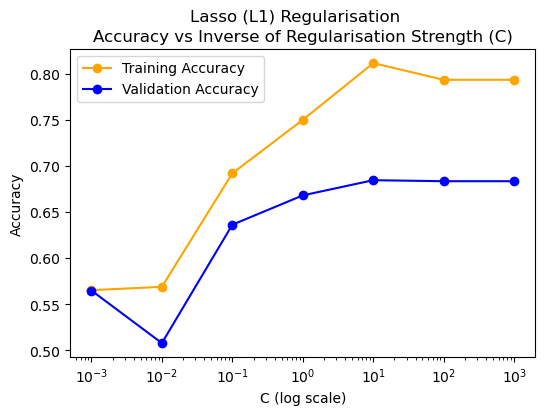

In [15]:
logreg = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)  # Setting a maximum number of iterations to prevent infinite search

# GridSearch with CV
grid_search = GridSearchCV(logreg, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True)
grid_search.fit(X_train, y_train)

# Extract results
results = grid_search.cv_results_
C_values = results['param_C'].data.astype(float)
mean_test = results['mean_test_score']
mean_train = results['mean_train_score']

# Plot with a logarithmic X-axis
plt.figure(figsize = (6, 4))
plt.semilogx(C_values, mean_train, marker = 'o', label = 'Training Accuracy', color = 'orange')
plt.semilogx(C_values, mean_test, marker = 'o', label = 'Validation Accuracy', color = 'blue')

plt.suptitle('Lasso (L1) Regularisation')
plt.title('Accuracy vs Inverse of Regularisation Strength (C)'); plt.xlabel('C (log scale)'); plt.ylabel('Accuracy'); plt.legend();

Choosing the right `C` value is ultimately a judgement call for the data scientist. It involves balancing the trade-off between fitting the training data well and achieving good validation performance, since too large or too small a value can either overfit or underfit the model.

### Ridge (L2) Regularisation  

Let’s now apply ridge regularisation using the `'liblinear'` solver; this solver also supports L2 regularisation

In [16]:
logreg_model = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 100); 
logreg_model.fit(X_train, y_train)  # Model fit
y_pred_train = logreg_model.predict(X_train); 
y_pred_test = logreg_model.predict(X_test)  # Predictions
acc_train = accuracy_score(y_train, y_pred_train); 
acc_test = accuracy_score(y_test, y_pred_test)  # Accuracies
print('Training accuracy =', np.round(acc_train, 2)); 
print('Testing accuracy =', np.round(acc_test, 2))

Training accuracy = 0.78
Testing accuracy = 0.77


We will use the same parameter grid for `C` as before

In [17]:
param_grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

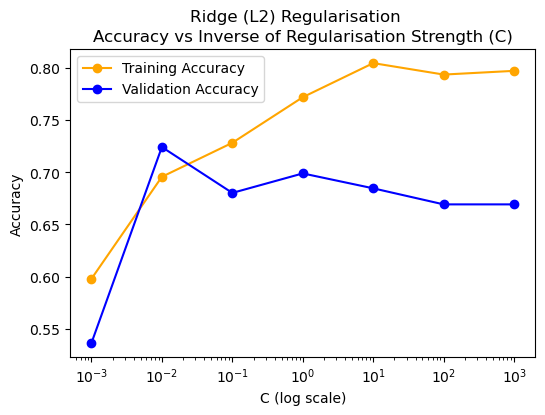

In [18]:
logreg = LogisticRegression(penalty = 'l2', solver = 'liblinear', max_iter = 1000)  # Setting a maximum number of iterations to prevent infinite search

# GridSearch with CV
grid_search = GridSearchCV(logreg, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True)
grid_search.fit(X_train, y_train)

# Extract results
results = grid_search.cv_results_
C_values = results['param_C'].data.astype(float)
mean_test = results['mean_test_score']
mean_train = results['mean_train_score']

# Plot with a logarithmic X-axis
plt.figure(figsize = (6, 4))
plt.semilogx(C_values, mean_train, marker = 'o', label = 'Training Accuracy', color = 'orange')
plt.semilogx(C_values, mean_test, marker = 'o', label = 'Validation Accuracy', color = 'blue')

plt.suptitle('Ridge (L2) Regularisation')
plt.title('Accuracy vs Inverse of Regularisation Strength (C)'); plt.xlabel('C (log scale)'); plt.ylabel('Accuracy'); plt.legend();

Once again, the final choice of `C` depends on you as the data scientist

### Comparison

Let's compare how our model coefficients change depending on the kind of regularisation; let's go for `C = 1` in both cases here

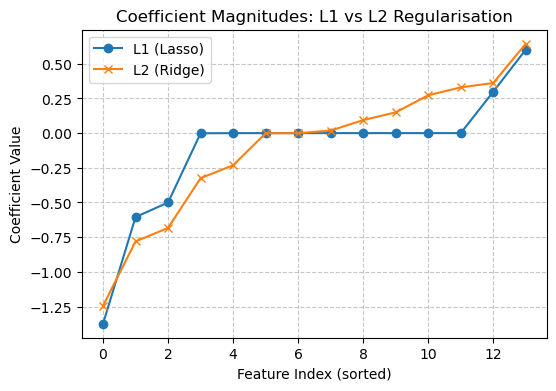

In [19]:
# Fit L1 and L2 models
logreg_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, max_iter = 1000).fit(X_train, y_train)
logreg_l2 = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 1, max_iter = 1000).fit(X_train, y_train)

# Coefficients
coef_l1 = logreg_l1.coef_.flatten()
coef_l2 = logreg_l2.coef_.flatten()

# Plot coefficient values against feature index
plt.figure(figsize = (6, 4))
plt.plot(np.sort(coef_l1), marker = 'o', label = 'L1 (Lasso)')
plt.plot(np.sort(coef_l2), marker = 'x', label = 'L2 (Ridge)')

plt.title('Coefficient Magnitudes: L1 vs L2 Regularisation'); plt.xlabel('Feature Index (sorted)'); plt.ylabel('Coefficient Value'); plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.7);

You can observe how lasso regression leads to harsher edges, while ridge regression tends to be smooth

Here are the differences between these two regularisation techniques

| Aspect                  | L1 Regularisation (Lasso)              | L2 Regularisation (Ridge)           |
|--------------------------|-----------------------------------------|--------------------------------------|
| Penalty Term            | Sum of absolute values of coefficients | Sum of squared values of coefficients |
| Effect on Coefficients  | Forces some coefficients to exactly 0 (feature selection) | Shrinks coefficients but rarely makes them 0 |
| Model Interpretation    | Produces sparse models, easier to interpret | Retains all features, less sparse |
| When Useful             | High-dimensional data, need feature selection | Multicollinearity, need stability |
| Solver Support (`sklearn`)| `'liblinear'`, `'saga'`                 | Most solvers (`'liblinear'`, `'lbfgs'`, `'saga'`, etc.) |